In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import csv
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KernelDensity, kneighbors_graph
from matplotlib import cm
from sklearn import cluster
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
import seaborn as sns

## Assignment 5

### Exercise 1

* Load the data on fragments of glass collected in forensic work from glass.txt.
* Estimate the density of the first variable (refractive in-dex) using a histogram and use a kernel density estimator (you can use histograms from numpy and kernel density estimators from sklearn). Use cross-validation to choose the amount of smoothing.
* Experiment with different binwidths and bandwidths.
* Plot the obtained densities.

In [2]:
glass = np.asarray(pd.read_csv('glass.txt', sep='\s+'))[:, :-1]

### Optimal binwidths

We want to minimize the following function

$$\hat{J}(h) = \frac{2}{(m-1)h} + \frac{m+1}{(m-1)h}\sum_{i=1}^N\left(\frac{v_i}{m}\right)^2$$

In [3]:
def J(N, m=glass.shape[0], data=glass[:, 0], a=min(glass[:, 0]), b=max(glass[:, 0])):
    v = np.histogram(data, bins=N)[0]
    h = (b - a) / N
    s = sum( (v[i] / m) ** 2 for i in range(N))
    return 2 / ((m - 1) * h) - (m + 1) * s / ((m - 1) * h)  

In [4]:
costs = []
for N in range(1, 100):
    costs.append(J(N))
    
bins_opt = np.argmin(costs) + 1

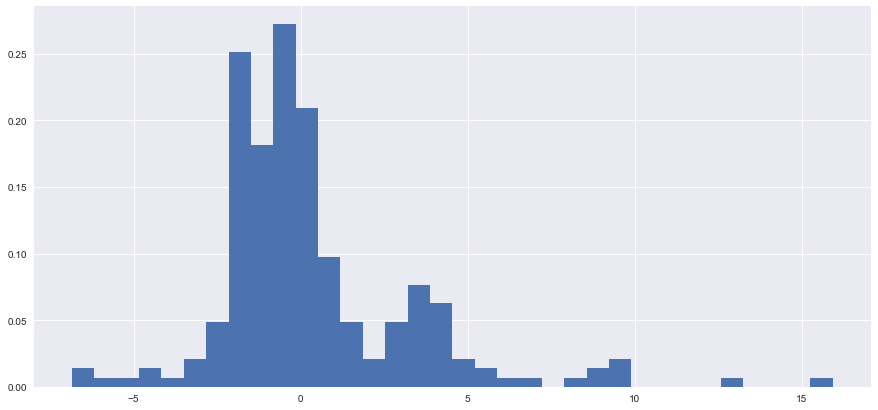

In [5]:
plt.figure(figsize=(15,7))
plt.hist(glass[:, 0], normed=True, bins=bins_opt)
plt.show()

In [6]:
X_plot = np.linspace(-10, 10, 1000).reshape(-1,1)
X = np.array(glass[:, 0]).reshape(-1,1)

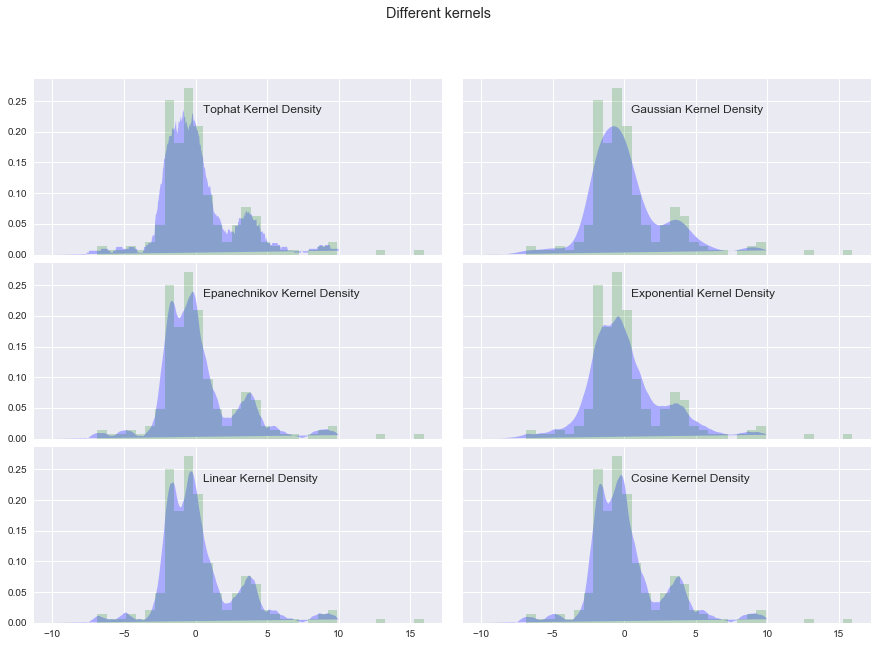

In [7]:
fig, ax = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(15,10))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# tophat KDE
kde = KernelDensity(kernel='tophat', bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[0, 0].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
ax[0, 0].text(0.5, 0.23, "Tophat Kernel Density")
ax[0, 0].hist(glass[:, 0], normed=True, alpha=.2, color='green', bins=bins_opt)

# Gaussian KDE
kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[0, 1].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
ax[0, 1].text(0.5, 0.23, "Gaussian Kernel Density")
ax[0, 1].hist(glass[:, 0], normed=True, alpha=.2, color='green', bins=bins_opt)

#Epanechnikov KDE
kde = KernelDensity(kernel='epanechnikov', bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[1, 0].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
ax[1, 0].text(0.5, 0.23, "Epanechnikov Kernel Density")
ax[1, 0].hist(glass[:, 0], normed=True, alpha=.2, color='green', bins=bins_opt)

#Exponential KDE
kde = KernelDensity(kernel='exponential', bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[1, 1].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
ax[1, 1].text(0.5, 0.23, "Exponential Kernel Density")
ax[1, 1].hist(glass[:, 0], normed=True, alpha=.2, color='green', bins=bins_opt)

#Linear KDE
kde = KernelDensity(kernel='linear', bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[2, 0].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
ax[2, 0].text(0.5, 0.23, "Linear Kernel Density")
ax[2, 0].hist(glass[:, 0], normed=True, alpha=.2, color='green', bins=bins_opt)

#Cosine KDE
kde = KernelDensity(kernel='cosine', bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[2, 1].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
ax[2, 1].text(0.5, 0.23, "Cosine Kernel Density")
ax[2, 1].hist(glass[:, 0], normed=True, alpha=.2, color='green', bins=bins_opt)

fig.suptitle("Different kernels")

### Optimal bandwidths for Gaussian, Exponential and Cosine kernels

In [8]:
# kernels = ['gaussian', 'epanechnikov', 'exponential', 'linear', 'cosine']
kernels = ['gaussian', 'exponential', 'cosine']
params = {'bandwidth': np.linspace(0.1, 10, 20)}

best_methods = []
best_params = []

for kernel in kernels:
    method = GridSearchCV(KernelDensity(kernel=kernel), params, cv=214)
    method.fit(glass[:, 0].reshape(-1, 1))
    best_methods.append(method.best_estimator_)
    best_params.append(method.best_params_)

//anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:593: RuntimeWarning: invalid value encountered in subtract
  array_means[:, np.newaxis]) ** 2,


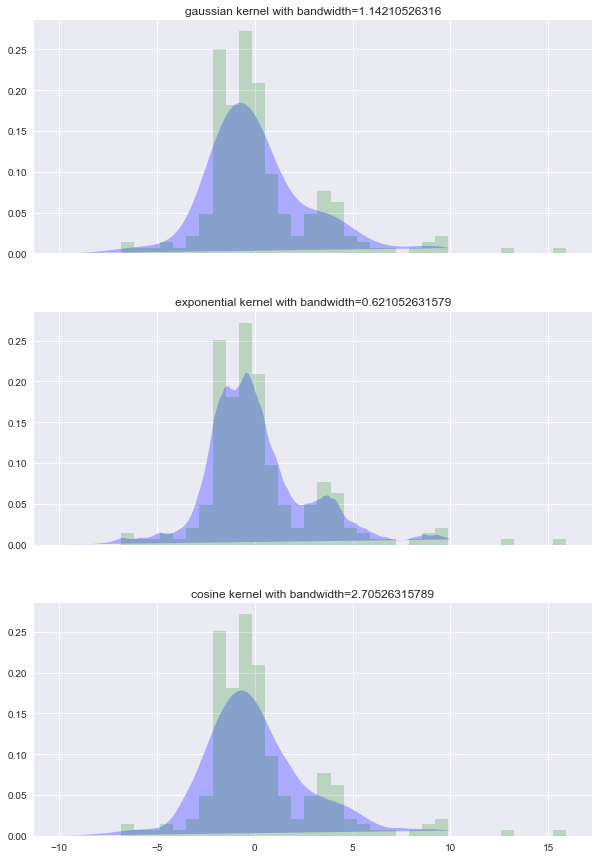

In [9]:
fig, ax = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(10,15))
fig.subplots_adjust(hspace=0.25, wspace=0.05)

for i in range(len(kernels)):
    
    kde = best_methods[i].fit(X)
    log_dens = kde.score_samples(X_plot)
    ax[i].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
    ax[i].set_title(kernels[i] + ' kernel with bandwidth=' + str(best_params[i]['bandwidth']))
    ax[i].hist(glass[:, 0], normed=True, alpha=.2, color='green', bins=bins_opt)
    
plt.show()

### Some experiments with Gaussian kernel

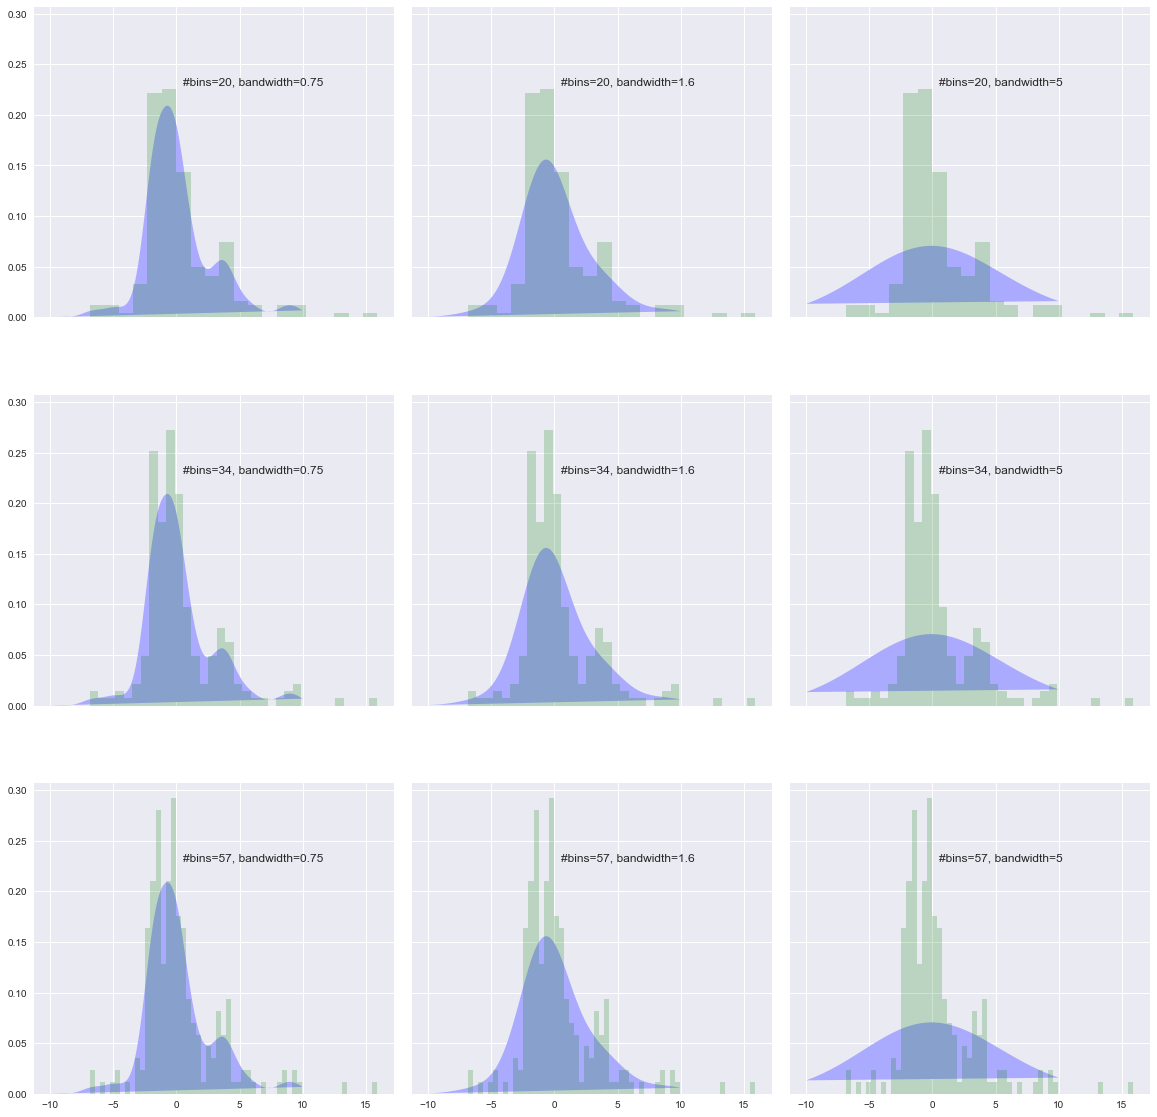

In [10]:
bins = [20, 34, 57]
bands = [0.75, 1.6, 5]

fig, ax = plt.subplots(len(bins), len(bands), sharex=True, sharey=True, figsize=(20,20))
fig.subplots_adjust(hspace=0.25, wspace=0.05)

for i in range(len(bins)):
    for j in range(len(bands)):
        kde = KernelDensity(kernel='gaussian', bandwidth=bands[j]).fit(X)
        log_dens = kde.score_samples(X_plot)
        ax[i, j].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
        ax[i, j].text(0.5, 0.23, "#bins=%s, bandwidth=%s" % (bins[i], bands[j]))
        ax[i, j].hist(glass[:, 0], normed=True, alpha=.2, color='green', bins=bins[i])

### Exercise 2

* Let $Y$ be refractive index and let $x$ be aluminum content (the fourth variable).
* Perform a nonparametric regression to fit the model $Y=f(x)+ \epsilon$. Use cross-validation to estimatethe bandwidth.
* Visualize your model and training data.

In [11]:
from statsmodels.nonparametric.kernel_regression import KernelReg

In [12]:
glass2 = pd.read_csv('glass.txt', sep='\s+')
x = glass2['Al']
y = glass2['RI']

In [13]:
regression = KernelReg(y, x, var_type='c', reg_type='lc', bw='cv_ls')

In [14]:
y_pred = regression.fit(x)

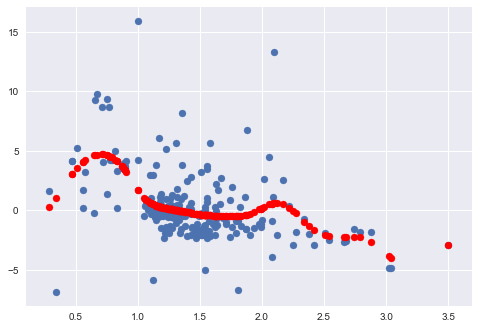

In [15]:
plt.scatter(x, y)
plt.scatter(x, y_pred[0], c='r')
plt.show()

### Exercise 3

* Load clustering.txt dataset
* Load the ground truth cluster labels from clustering_labels.txt
* Try KMeans, Gaussian Mixture and 2 more clustering algorithms from sklearn. Try small number of clusters, right number of clusters and large number of clusters. Visualize the results and calculate 2 clustering metrics: silhouette score and adjusted mutual information.
* Using boostrap calculate confidence intervals for clustering metrics:
  * generate bootstrap samples
  * for each sample make clustering and calculate metrics
  * Estimate variance of metrics
  * Construct normal 95% confidence interval.
* Make conclusion.

In [16]:
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score

In [17]:
clustering = np.loadtxt('clustering.txt')
clustering_labels = np.loadtxt('clustering_labels.txt')
clustering_colors = [cm.Vega10(c / float(max(clustering_labels))) for c in clustering_labels]

In [18]:
num_clusters = [5, 15, 27]

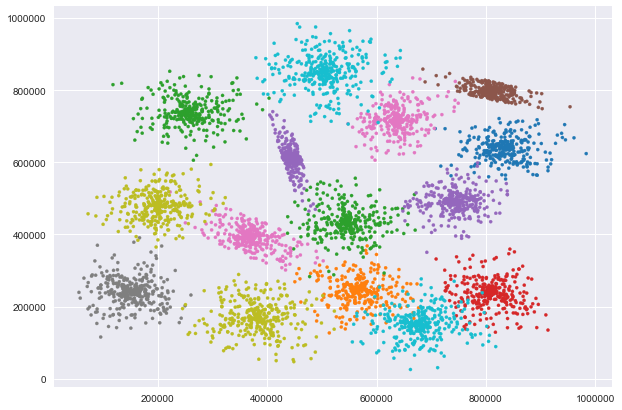

In [19]:
#visualization of all clusters without colours
plt.figure(figsize=(10,7))
plt.scatter(clustering[:,0], clustering[:,1], c=clustering_colors, s=10)

In [20]:
def plot_clustering(method, cl_data=clustering, num_clusters=num_clusters, true_labels=clustering_labels):
    plt.figure(figsize = (10, 5))
    method.fit(cl_data)
    predicted_clusters = method.predict(cl_data)
    ss = silhouette_score(cl_data, predicted_clusters)
    amis = adjusted_mutual_info_score(true_labels, predicted_clusters)
    C = len(set(predicted_clusters))
    colors = [cm.Vega10(c) for c in predicted_clusters]
    plt.scatter(cl_data[:, 0], cl_data[:, 1], color = colors, edgecolors='none', s = 3)
    plt.title("%s \n \n Silhouette score= %s \n Adjusted mutual information= %s" %(method, ss, amis))

In [21]:
def score(method, cl_data=clustering, num_clusters=num_clusters, true_labels=clustering_labels):
    method.fit(cl_data)
    predicted_clusters = method.predict(cl_data)
    ss = silhouette_score(cl_data, predicted_clusters)
    amis = adjusted_mutual_info_score(true_labels, predicted_clusters)
    return ss, amis

### KMeans

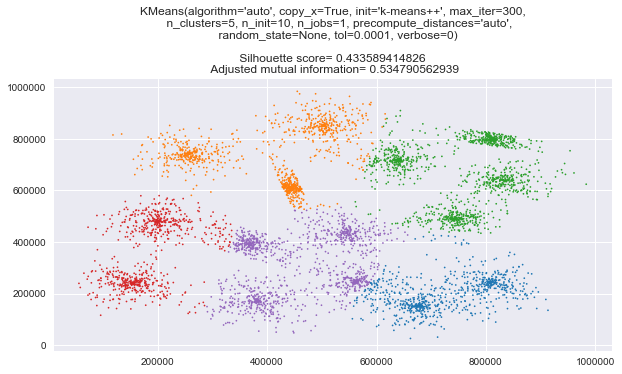

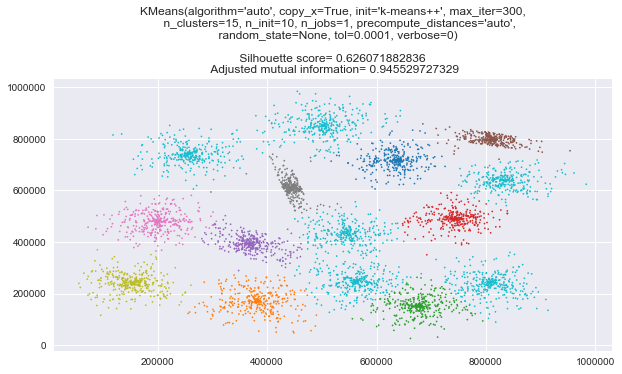

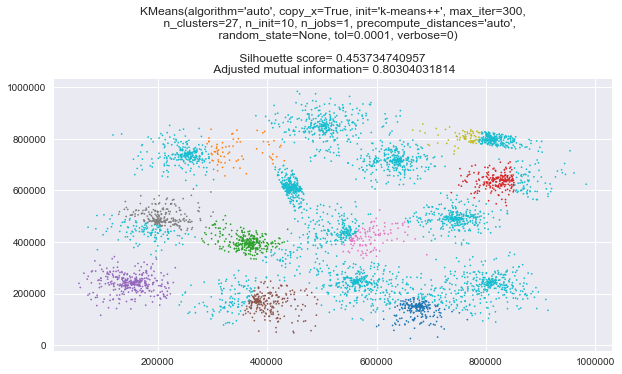

In [22]:
for i in range(len(num_clusters)):
    plot_clustering(cluster.KMeans(n_clusters=num_clusters[i]))

### GaussianMixture

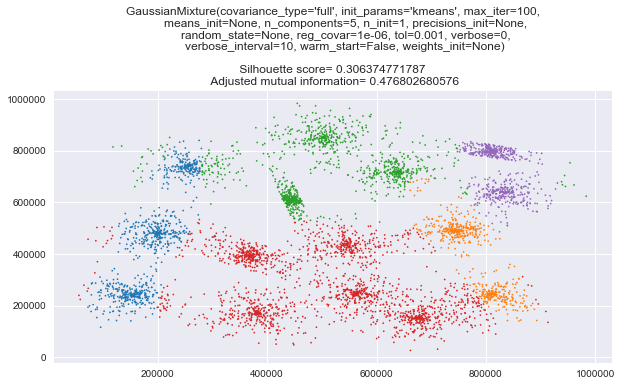

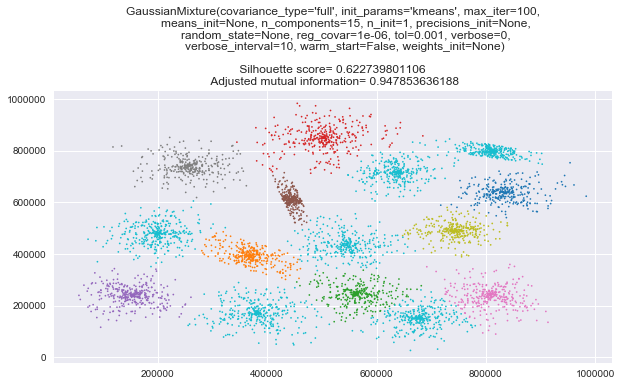

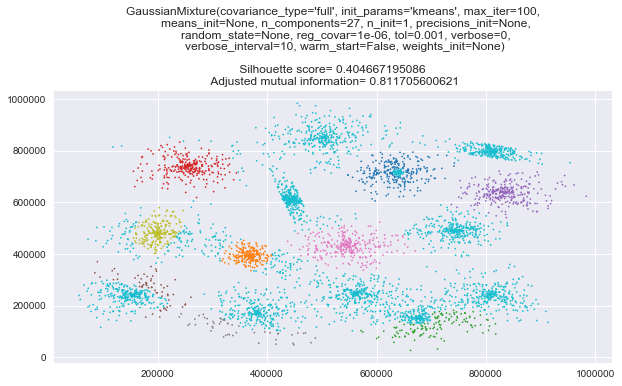

In [23]:
for i in range(len(num_clusters)):
    plot_clustering(GaussianMixture(n_components=num_clusters[i]))

### Ward hierarchical clustering

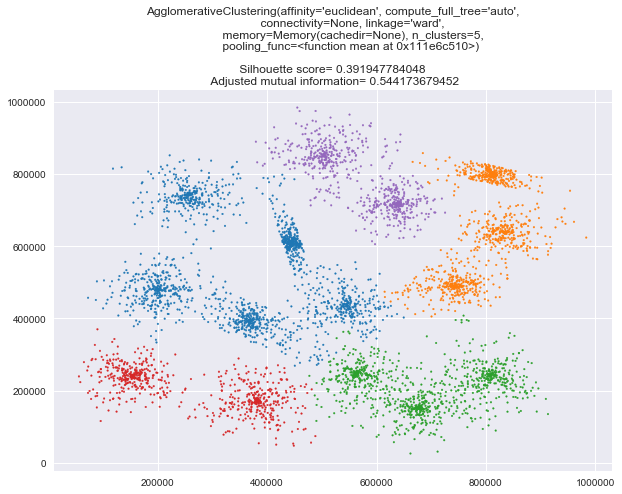

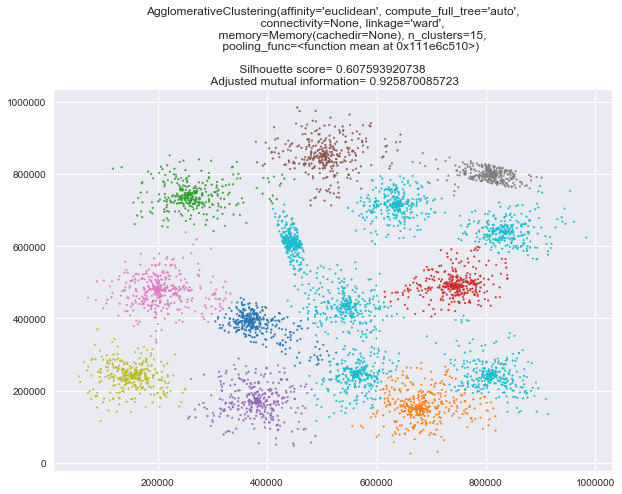

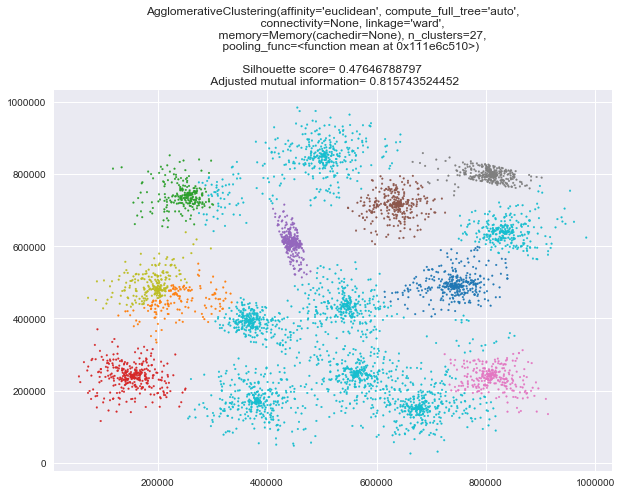

In [24]:
for i in range(len(num_clusters)):
    method = cluster.AgglomerativeClustering(n_clusters=num_clusters[i], linkage="ward").fit(clustering)
    pred_labels = method.labels_
    ss = silhouette_score(clustering, pred_labels)
    amis = adjusted_mutual_info_score(clustering_labels, pred_labels)
    #visualization of all clusters without colours
    plt.figure(figsize=(10,7))
    plt.scatter(clustering[:,0], clustering[:,1], c=cm.Vega10(pred_labels), s=3)
    plt.title("%s \n \n Silhouette score= %s \n Adjusted mutual information= %s" %(method, ss, amis))

### AgglomerativeClustering

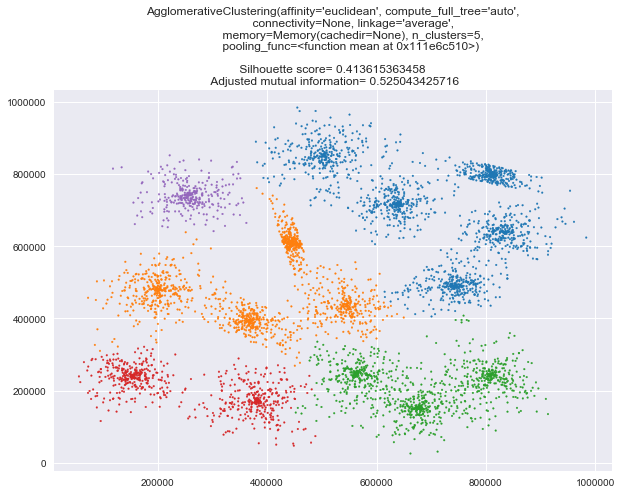

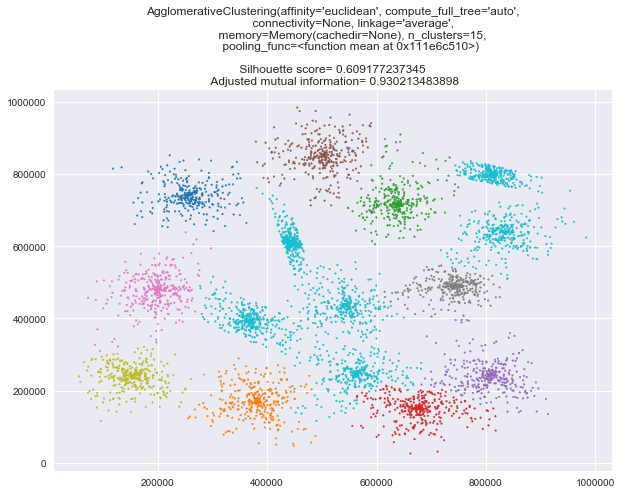

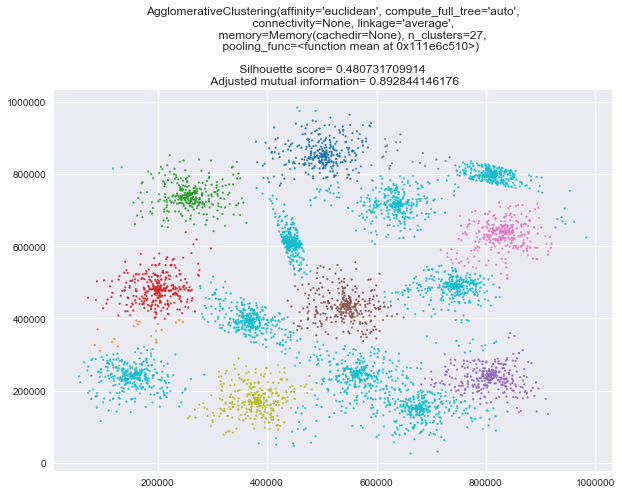

In [25]:
for i in range(len(num_clusters)):
    method = cluster.AgglomerativeClustering(n_clusters=num_clusters[i], linkage="average").fit(clustering)
    pred_labels = method.labels_
    ss = silhouette_score(clustering, pred_labels)
    amis = adjusted_mutual_info_score(clustering_labels, pred_labels)
    #visualization of all clusters without colours
    plt.figure(figsize=(10,7))
    plt.scatter(clustering[:,0], clustering[:,1], c=cm.Vega10(pred_labels), s=3)
    plt.title("%s \n \n Silhouette score= %s \n Adjusted mutual information= %s" %(method, ss, amis))

### Bootstrap

In [26]:
from sklearn.utils import resample
import scipy as sci

In [27]:
def bootstrap(method, data=clustering, n_bootstrap_samples=10, is_predict=True, clustering_labels=clustering_labels):
   
    print(method, '\n')
    
    indicies = range(len(clustering))

    ss = []
    amis = []

    if is_predict:
        for i in range(n_bootstrap_samples):
            bootstrap_indicies = resample(indicies)
            bootstrap_data = data[bootstrap_indicies, :]
            bootstrap_labels = clustering_labels[bootstrap_indicies]
            scores = score(method, cl_data=bootstrap_data, true_labels= bootstrap_labels)
            ss.append(scores[0])
            amis.append(scores[1])
    
    if not is_predict:
        for i in range(n_bootstrap_samples):
            bootstrap_indicies = resample(indicies)
            bootstrap_data = data[bootstrap_indicies, :]
            bootstrap_labels = clustering_labels[bootstrap_indicies]
            method.fit(bootstrap_data)
            pred_labels = method.labels_
            scores = (silhouette_score(clustering, pred_labels), 
                     adjusted_mutual_info_score(clustering_labels, pred_labels))
            ss.append(scores[0])
            amis.append(scores[1])
        
    ss_std = np.std(ss)
    amis_std = np.std(amis)
            

    print('Silhouette score variance=', ss_std ** 2, '\nAdjusted mutual information=', amis_std ** 2, '\n')

    if is_predict:
        up_ss = score(method, cl_data=data)[0] +  sci.stats.norm.ppf(0.975) * ss_std
        up_amis = score(method, cl_data=data)[1] +  sci.stats.norm.ppf(0.975) * amis_std

        low_ss = score(method, cl_data=data)[0] -  sci.stats.norm.ppf(0.975) * ss_std
        low_amis = score(method, cl_data=data)[1] -  sci.stats.norm.ppf(0.975) * amis_std
    
    if not is_predict:
        method.fit(data)
        pred_labels = method.labels_
        scores = (silhouette_score(clustering, pred_labels), 
                  adjusted_mutual_info_score(clustering_labels, pred_labels))
        
#         print (scores)
        up_ss = scores[0] +  sci.stats.norm.ppf(0.975) * ss_std
        up_amis = scores[1] +  sci.stats.norm.ppf(0.975) * amis_std

        low_ss = scores[0] -  sci.stats.norm.ppf(0.975) * ss_std
        low_amis = scores[1] -  sci.stats.norm.ppf(0.975) * amis_std

    print ('Silhouette normal 95% confidence interval','[%s, %s]' % (low_ss, up_ss))
    print ('Adjusted mutual information normal 95% confidence interval', '[%s, %s]' % (low_amis, up_amis))
    
    return (low_ss, up_ss), (low_amis, up_amis)

In [28]:
conf_int_ss = []
conf_int_amis = []

In [29]:
results = bootstrap(cluster.KMeans(n_clusters=15))
conf_int_ss.append(results[0])
conf_int_amis.append(results[1])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=15, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0) 

Silhouette score variance= 2.15556682861e-05 
Adjusted mutual information= 1.39461012113e-05 

Silhouette normal 95% confidence interval [0.616972145912, 0.635171619759]
Adjusted mutual information normal 95% confidence interval [0.938210343918, 0.953171381052]


In [30]:
results = bootstrap(GaussianMixture(n_components=15))
conf_int_ss.append(results[0])
conf_int_amis.append(results[1])

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=15, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None) 

Silhouette score variance= 0.000703886397457 
Adjusted mutual information= 0.000254120952873 

Silhouette normal 95% confidence interval [0.570721213059, 0.674668596143]
Adjusted mutual information normal 95% confidence interval [0.886178559271, 0.95267423886]


In [31]:
results = bootstrap(cluster.AgglomerativeClustering(n_clusters=15, linkage="ward"), is_predict=False)
conf_int_ss.append(results[0])
conf_int_amis.append(results[1])

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward',
            memory=Memory(cachedir=None), n_clusters=15,
            pooling_func=<function mean at 0x111e6c510>) 

Silhouette score variance= 2.11888897828e-05 
Adjusted mutual information= 5.97548169506e-07 

Silhouette normal 95% confidence interval [0.598571933842, 0.616615907634]
Adjusted mutual information normal 95% confidence interval [0.924355009261, 0.927385162185]


In [32]:
results = bootstrap(cluster.AgglomerativeClustering(n_clusters=15, linkage="average"), is_predict=False)
conf_int_ss.append(results[0])
conf_int_amis.append(results[1])

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='average',
            memory=Memory(cachedir=None), n_clusters=15,
            pooling_func=<function mean at 0x111e6c510>) 

Silhouette score variance= 0.00869107191782 
Adjusted mutual information= 4.14122971557e-07 

Silhouette normal 95% confidence interval [0.426457794263, 0.791896680426]
Adjusted mutual information normal 95% confidence interval [0.928952200289, 0.931474767507]


### Conclusion

In [33]:
pd.DataFrame({'Algorithm': ['KMeans', 'GaussianMixture', 'AgglomerativeClustering', 'WardHierarchicalClustering'],
              'Normal confidence interval for Silhouette ': conf_int_ss,
              'Normal confidence interval for Adjusted mutual information': conf_int_amis})

,Algorithm,Normal confidence interval for Adjusted mutual information,Normal confidence interval for Silhouette
0,KMeans,"(0.938210343918, 0.953171381052)","(0.616972145912, 0.635171619759)"
1,GaussianMixture,"(0.886178559271, 0.95267423886)","(0.570721213059, 0.674668596143)"
2,AgglomerativeClustering,"(0.924355009261, 0.927385162185)","(0.598571933842, 0.616615907634)"
3,WardHierarchicalClustering,"(0.928952200289, 0.931474767507)","(0.426457794263, 0.791896680426)"
